In [2]:
import netCDF4 as nc
import glob
import numpy as np
fs=glob.glob("output/subset_*.nc")
fs=sorted(fs)
y_lastbin=[]

x_data=[]
y_data=[]
p_type_data=[]
n_seq_data=[]
#print(fs)
y_nonz=[[]for k in range(44+18)]
x_nonz=[[]for k in range(44+18)]
xL=[]
yL=[]
diffL=[]
for f in fs:
    with nc.Dataset(f) as fh:
        bin_nodes=fh.variables['bin_nodes'][:]
        diffL.extend(bin_nodes[:,-1]-(bin_nodes[:,2]-2))

print(np.array(diffL).min(),np.array(diffL).max())


-11 18


In [3]:
import matplotlib.pyplot as plt
#h=plt.hist(diffL,bins=20)

In [26]:

x_data=[]
y_data=[]
p_type_data=[]
n_seq_data=[]
bin_data=[]
z_meas2L=[]
bin_nodesL=[]
for f in fs:
    with nc.Dataset(f) as fh:
        
        vars=fh.variables.keys()
        z_meas=fh.variables['z_meas'][:]
        p_type=fh.variables['p_type'][:]
        bin_nodes=fh.variables['bin_nodes'][:]
        sfc_bin=fh.variables['sfc_bin'][:]
        p_rate_cmb=fh.variables['p_rate_cmb'][:]
        dm=fh.variables['dm'][:]
        bin_zero_deg=fh.variables['bin_zero_deg'][:]
        bin_storm_top=fh.variables['bin_storm_top'][:]
        z_meas2=np.log10(0.5*10**(z_meas[:,::2]/10)+0.5*10**(z_meas[:,1::2]/10)+1e-9)*10
        z_meas2[z_meas2<0]=0
        for i,z_meas_1d in enumerate(z_meas2):
            #if p_type[i]==3:
            #    continue
            itop=bin_storm_top[i]//2
            x_1d=[]
            y_1d=[]
            i_valid=0
            bin_1d=[]
            for k1 in range(bin_nodes[i,0],bin_nodes[i,-1]): 
                x_1d.append([z_meas_1d[k1,0],z_meas_1d[k1,1],k1-bin_nodes[i,2]])
                y_1d.append([np.log10(1+p_rate_cmb[i,k1]/0.1),dm[i,k1]])
                bin_1d.append(k1-bin_nodes[i,2])
                i_valid+=1
            
            if(i_valid>0):
                n_seq_data.append(i_valid)
                bin_data.extend(bin_1d)
                x_data.append(x_1d)
                y_data.append(y_1d)
                p_type_data.append(p_type[i])
                z_meas2L.append(z_meas_1d.copy())
                bin_nodesL.append(bin_nodes[i,:])
        #break

#vars='z_meas', 'p_type', 'bin_nodes', 'sfc_bin', 'p_rate_cmb', 'dm', 'bin_zero_deg', 'bin_storm_top'


In [27]:
#plt.plot(x_data[25000][:,0])
n_all=len(x_data)
print(n_all)
x_data_unpacked=np.zeros((n_all,60,3),np.float32)
y_data_unpacked=np.zeros((n_all,60,2),np.float32)
z_meas2L=np.array(z_meas2L)
bin_nodesL=np.array(bin_nodesL)
for i in range(n_all):
    nz=len(x_data[i])
    x_data_unpacked[i,:nz,:]=np.array(x_data[i])
    x_data_unpacked[i,:nz,:2]=(x_data_unpacked[i,:nz,:2]-12)/8
    x_data_unpacked[i,:nz,2:3]/=8.0
    y_data_unpacked[i,:nz,:]=np.array(y_data[i])



106679


In [28]:
import numpy as np
ix=np.random.randint(0,n_all)
#ix=3000
print(z_meas2L.shape,n_all)

for k in range(bin_nodesL[ix,0],bin_nodesL[ix,-1]):
    x1=[z_meas2L[ix][k,0],z_meas2L[ix][k,1],k-bin_nodesL[ix,2]]
    x1[0]=(x1[0]-12)/8
    x1[1]=(x1[1]-12)/8
    x1[2]=x1[2]/8
    xL.append(x1)
    print(np.array(x1),x_data_unpacked[ix,k-bin_nodesL[ix,0],:])

(106679, 88, 2) 106679
[ 0.08744048 -0.85878745 -0.75      ] [ 0.08744049 -0.8587875  -0.75      ]
[ 0.41375575 -1.5        -0.625     ] [ 0.41375577 -1.5        -0.625     ]
[ 0.21044837 -0.48125005 -0.5       ] [ 0.21044838 -0.48125005 -0.5       ]
[-0.12507616 -0.85753754 -0.375     ] [-0.12507617 -0.85753757 -0.375     ]
[-0.00327677 -0.85628751 -0.25      ] [-0.00327682 -0.85628754 -0.25      ]
[-0.68128744 -0.37379108 -0.125     ] [-0.68128747 -0.3737911  -0.125     ]
[-0.33907254 -1.5         0.        ] [-0.3390726 -1.5        0.       ]
[ 0.25538576 -1.5         0.125     ] [ 0.25538576 -1.5         0.125     ]
[-1.5        -0.85378746  0.25      ] [-1.5       -0.8537875  0.25     ]
[-0.16886167 -1.5         0.375     ] [-0.16886163 -1.5         0.375     ]
[-0.2129343 -1.5        0.5      ] [-0.21293426 -1.5         0.5       ]


In [8]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class LSTMPackedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPackedModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Final output layer
    
    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply the output layer to the LSTM output
        output = self.fc(output)
        
        return output

# Example usage:
# Assume input is a padded batch with variable sequence lengths
batch_size = 3
seq_lengths = torch.tensor([4, 2, 1])  # Variable lengths of the sequences
input_size = 10
hidden_size = 20
num_layers = 2
output_size = 5

model = LSTMPackedModel(input_size, hidden_size, num_layers, output_size)

# Create a batch of padded inputs with variable lengths
padded_input = torch.randn(batch_size, seq_lengths.max(), input_size)

# Forward pass
output = model(padded_input, seq_lengths)


In [29]:
x_data_n=np.array(x_data_unpacked)
y_data_n=np.array(y_data_unpacked)
print(x_data_n.shape)
print(y_data_n.shape)
x_data_n=x_data_n
y_data_n=y_data_n
x_data_t=torch.tensor(x_data_n,dtype=torch.float32)
y_data_t=torch.tensor(y_data_n,dtype=torch.float32)
n_seq_data_t=torch.tensor(n_seq_data,dtype=torch.int32)
p_type_data=np.array(p_type_data)
a=np.nonzero(p_type_data>0)[0]

x_data_conv=x_data_t[a]
y_data_conv=y_data_t[a]
n_seq_data_conv=n_seq_data_t[a]

a=np.nonzero(p_type_data==1)[0]
x_data_strat=x_data_t[a]
y_data_strat=y_data_t[a]
n_seq_data_strat=n_seq_data_t[a]

(106679, 60, 3)
(106679, 60, 2)


In [35]:
print(p_type_data[a].shape)
a=np.nonzero(p_type_data>=0)[0]
print(n_seq_data)
x_data_strat_n=torch.tensor(x_data_n[a],dtype=torch.float32)
y_data_strat_n=torch.tensor(y_data_n[a],dtype=torch.float32)
n_seq_data_strat=torch.tensor(np.array(n_seq_data)[a],dtype=torch.int32)
z_meas2_strat=z_meas2L[a]
bin_nodesL_strat=bin_nodesL[a]
strat_data=torch.utils.data.TensorDataset(x_data_strat_n[::2,:,:],y_data_strat_n[::2,:,:],n_seq_data_strat[::2])
strat_loader=torch.utils.data.DataLoader(strat_data,batch_size=64,shuffle=True)
z_meas2_2=z_meas2_strat[::2]
bin_nodes_2=bin_nodesL_strat[::2]
print(z_meas2L.shape)
print(bin_nodesL.shape)
print(z_meas2_2.shape)  
print(x_data_strat_n.shape)
print(x_data_strat_n.shape)
print(z_meas2_strat.shape)



(106679,)
[7, 7, 6, 6, 7, 6, 5, 6, 8, 5, 9, 8, 8, 12, 10, 10, 9, 10, 11, 11, 12, 10, 10, 9, 7, 10, 11, 11, 11, 11, 9, 12, 14, 11, 9, 9, 12, 11, 10, 2, 12, 10, 10, 10, 10, 8, 8, 8, 12, 12, 12, 8, 9, 11, 8, 8, 8, 10, 11, 12, 10, 7, 7, 7, 8, 6, 8, 11, 13, 16, 9, 14, 12, 13, 10, 6, 7, 7, 7, 8, 10, 11, 13, 16, 14, 10, 13, 12, 8, 6, 5, 8, 6, 8, 9, 9, 9, 13, 12, 11, 10, 10, 6, 3, 4, 6, 7, 11, 8, 9, 10, 13, 14, 11, 10, 12, 9, 3, 8, 11, 10, 8, 7, 11, 13, 13, 10, 3, 9, 7, 4, 3, 5, 9, 11, 9, 9, 8, 12, 11, 12, 11, 10, 13, 9, 11, 5, 3, 4, 9, 9, 9, 8, 5, 13, 13, 12, 10, 10, 9, 11, 11, 6, 2, 7, 9, 8, 8, 7, 6, 12, 13, 10, 11, 10, 11, 10, 4, 2, 3, 1, 7, 8, 8, 6, 6, 8, 5, 9, 8, 10, 9, 10, 9, 11, 2, 5, 4, 7, 7, 8, 5, 7, 8, 5, 5, 11, 8, 8, 13, 10, 9, 8, 3, 9, 10, 8, 10, 11, 6, 7, 7, 6, 11, 12, 12, 11, 10, 11, 9, 9, 4, 9, 7, 11, 9, 11, 10, 8, 8, 5, 4, 7, 12, 11, 14, 11, 9, 12, 9, 2, 7, 8, 10, 11, 10, 10, 12, 10, 9, 8, 6, 7, 9, 12, 10, 10, 9, 11, 13, 6, 12, 9, 9, 11, 12, 11, 11, 9, 12, 12, 10, 11, 11, 10, 9

In [50]:

nx=len(strat_data)
print(nx,z_meas2_2.shape)
ix=np.random.randint(0,nx)
#ix=10
print(bin_nodesL[ix],nx)
xL=[]
ik=0
for k in []:#range(bin_nodesL_strat[ix,0],bin_nodesL_strat[ix,-1]):
    x1=[z_meas2_strat[ix][k,0],z_meas2_strat[ix][k,1],k-bin_nodesL_strat[ix,2]]
    x1=[z_meas2_strat[ix][k,0],z_meas2_strat[ix][k,1],k-bin_nodesL_strat[ix,2]]
    x1[0]=(x1[0]-12)/8
    x1[1]=(x1[1]-12)/8
    x1[2]=x1[2]/8
    xL.append(x1)
    print(np.array(x1),x_data_strat_n[ix].detach().numpy()[ik,:])
    ik+=1
ik=0
for k in range(bin_nodes_2[ix,0],bin_nodes_2[ix,-1]):
    x1=[z_meas2_2[ix][k,0],z_meas2_2[ix][k,1],k-bin_nodes_2[ix,2]]
    x1[0]=(x1[0]-12)/8
    x1[1]=(x1[1]-12)/8
    x1[2]=x1[2]/8
    xL.append(x1)
    print(np.array(x1),x_data_strat_n[ix*2].detach().numpy()[ik,:])
    ik+=1
#print(xL)
#print(y_data_strat_n[ix])



53340 (53340, 88, 2)
[46 67 71 73 82] 53340
[ 0.60011793  0.62582993 -1.        ] [ 0.6001179   0.62582994 -1.        ]
[ 0.53969807 -0.01378754 -0.875     ] [ 0.5396981  -0.01378751 -0.875     ]
[ 0.66036733 -1.5        -0.75      ] [ 0.66036725 -1.5        -0.75      ]
[ 0.75656569  0.36940413 -0.625     ] [ 0.7565658   0.36940408 -0.625     ]
[ 0.64242714  0.27188779 -0.5       ] [ 0.6424272   0.27188778 -0.5       ]
[ 1.06307545  0.27518244 -0.375     ] [ 1.0630755  0.2751825 -0.375    ]
[ 1.06882239  0.98625136 -0.25      ] [ 1.0688224   0.98625135 -0.25      ]
[ 1.1081685   0.70953113 -0.125     ] [ 1.1081686   0.70953107 -0.125     ]
[1.52895676 0.72306932 0.        ] [1.5289567 0.7230694 0.       ]
[1.52484982 0.71134179 0.125     ] [1.5248499  0.71134186 0.125     ]
[1.26079989 1.1383386  0.25      ] [1.2607999 1.1383386 0.25     ]
[1.15911171 1.36250139 0.375     ] [1.1591117 1.3625014 0.375    ]
[1.01222228 1.36708653 0.5       ] [1.0122223 1.3670864 0.5      ]


In [62]:
n_epoch=10
model_strat=LSTMPackedModel(3,64,3,2)
strat_criterion=nn.MSELoss(reduction='none')
strat_optimizer=torch.optim.Adam(model_strat.parameters(),lr=0.001)
model_ku_strat=LSTMPackedModel(2,64,3,2)
strat_ku_optimizer=torch.optim.Adam(model_ku_strat.parameters(),lr=0.001)
a_feat=[0,2]


In [60]:

for epoch in range(n_epoch):
    running_loss=0
    for x,y,n_seq in strat_loader:
        strat_optimizer.zero_grad()
        y_pred=model_strat(x,n_seq)
        n_seq1=y_pred.shape[1]
       
        loss=strat_criterion(y_pred,y[:,:n_seq1,:])
        mask=torch.arange(n_seq1).expand(y.shape[0],n_seq1)<n_seq.unsqueeze(1)
        
        masked_loss=(loss*mask.unsqueeze(2)).sum()
        masked_loss=masked_loss/mask.sum()
    
        masked_loss.backward()
        running_loss+=masked_loss.item()
        strat_optimizer.step()
    print(epoch,running_loss/len(strat_loader))

0 0.030716084425138842
1 0.03038693438965282
2 0.03018981280649523
3 0.03019484931187664
4 0.02999484528088384
5 0.02974260208248306
6 0.029603797884331904
7 0.029517728933613364
8 0.0295057896261128
9 0.02910351406613128


In [ ]:
for epoch in range(n_epoch):
    running_loss=0
    for x,y,n_seq in strat_loader:
        strat_ku_optimizer.zero_grad()
        y_pred=model_ku_strat(x[:,:,a_feat],n_seq)
        n_seq1=y_pred.shape[1]
       
        loss=strat_criterion(y_pred,y[:,:n_seq1,:2])
        mask=torch.arange(n_seq1).expand(y.shape[0],n_seq1)<n_seq.unsqueeze(1)
        
        masked_loss=(loss*mask.unsqueeze(2)).sum()
        masked_loss=masked_loss/mask.sum()
    
        masked_loss.backward()
        running_loss+=masked_loss.item()
        strat_ku_optimizer.step()
    print(epoch,running_loss/len(strat_loader))

0 0.03449178049541849
1 0.03447961658284032
2 0.03437462921881919
3 0.034343278710004525


In [ ]:
print(x.shape)
print(y.shape)
print(n_seq.shape)
scripted_model_strat=torch.jit.script(model_strat)
scripted_model_strat.save("conv_and_strat_model_jan28_2025.pt")
scripted_model_ku_strat=torch.jit.script(model_ku_strat)
scripted_model_ku_strat.save("conv_and_strat_ku_model_jan28_2025.pt")

torch.Size([28, 60, 3])
torch.Size([28, 60, 2])
torch.Size([28])


In [55]:
model_strat.eval()
output=model_strat(x_data_strat_n[::2,:,:],n_seq_data_strat[::2])

In [58]:
output_np=output.detach().numpy()
import pickle
pickle_out={"output":output_np,"y_data":y_data_strat_n[::2,:,:].detach().numpy(),"x_data":x_data_strat_n[::2,:,:].detach().numpy(),"n_seq":n_seq_data_strat[::2].detach().numpy(),"z_meas":z_meas2_strat[::2],"bin_nodes":bin_nodesL_strat[::2]}
pickle.dump(pickle_out,open("output_strat_jan28_2025.pkl","wb"))

In [61]:
torch.onnx.export(model_strat,(x[:1],n_seq[:1]),'conv_and_strat_model_kuka_jan24_2025.onnx',export_params=True,opset_version=11,do_constant_folding=True,input_names=['input','n_seq'],output_names=['output'])

[W128 13:50:51.682875000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W128 13:50:51.684079000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W128 13:50:51.894132000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PadPacked type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)


In [62]:
print((type(n_seq_data[0])))



<class 'int'>


In [13]:
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model_path = "strat_model_kuka_jan24_2015.onnx"
ort_session = ort.InferenceSession(onnx_model_path)

# Prepare input data
input_data = x.detach().numpy()
lengths_data = n_seq.detach().numpy()
outputs_numpy=model_strat(x,n_seq).detach().numpy()


In [69]:

np.savez('input_data.npz',input=input_data,n_seq=lengths_data,output=outputs_numpy)


In [14]:


# Run inference
outputs = ort_session.run(None, {'input': input_data, 'n_seq': lengths_data})
torch_output=model_strat(x,n_seq)

print(np.corrcoef(outputs[0].flatten(),y.detach().numpy().flatten()))
print(outputs[0].shape)
print(torch_output.shape)
plt.scatter(outputs[0][:,:36,:].flatten(),torch_output.detach().numpy().flatten())

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: n_seq for the following indices
 index: 0 Got: 10 Expected: 1
 Please fix either the inputs/outputs or the model.

In [121]:
outputs=model_strat(x_data_strat_n,n_seq_data_strat)
y_pred=[]
y_targ=[]
for i,output in enumerate(outputs):
    n_seq=n_seq_data_strat[i]
    y_pred.append(output[n_seq-1].detach().numpy())
    y_targ.append(y_data_strat_n[i,n_seq-1].numpy())


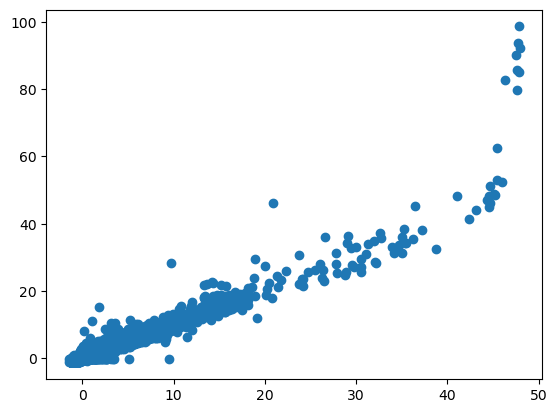

In [134]:
#plt.scatter(np.array(y_pred)[:,0],np.array(y_targ)[:,0])
#plt.plot(y_data_strat_mean[:,0])
#plt.plot(y_data_strat_std[:,0])
#print(y_data_strat_n.shape)
#h1=plt.hist(y_data_strat_n[:,:,0].flatten(),bins=np.arange(-2,5,0.1))
#print(np.corrcoef(np.array(y_pred)[:,1],np.array(y_targ)[:,1]))
print()
plt.scatter(np.array(y_pred)[:,0],np.array(y_targ)[:,0])
ind_max=np.argmax(np.array(y_targ)[:,0])


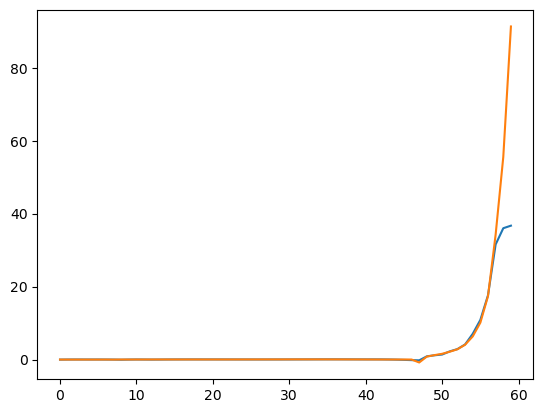

In [136]:
#print()
it=ind_max
n1=n_seq_data_strat[it]
plt.plot(outputs[it,:n1,1].detach().numpy())
plt.plot(y_data_strat_n[it,:n1,1].numpy())

In [73]:
x_data_conv_mean=torch.mean(x_data_conv,dim=0)
x_data_conv_std=torch.std(x_data_conv,dim=0)
x_data_conv_n=(x_data_conv-x_data_conv_mean)/x_data_conv_std
y_data_conv_mean=torch.mean(y_data_conv,dim=0)
y_data_conv_std=torch.std(y_data_conv,dim=0)
y_data_conv_n=(y_data_conv-y_data_conv_mean)/y_data_conv_std
conv_data=torch.utils.data.TensorDataset(x_data_conv_n,y_data_conv_n,n_seq_data_conv)
train_loader=torch.utils.data.DataLoader(conv_data,batch_size=32,shuffle=True)
# gaussian noise (3,3)
input_size=2
hidden_size=16
num_layers=2
output_size=2

model_conv=LSTMPackedModel(input_size,hidden_size,num_layers,output_size)

import torch.optim as optim
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model_conv.parameters(), lr=0.001)

In [74]:
n_epoch=20
for epoch in range(n_epoch):
    running_loss=0.0
    for i,data in enumerate(train_loader,0):
        inputs,targets,lengths=data
        optimizer.zero_grad()
        outputs=model_conv(inputs,lengths)
        n_batch,n_seq,n_feature=outputs.shape
        #print(n_batch,n_seq,n_feature)
        #print(targets.shape)
        loss=criterion(outputs,targets[:,:n_seq,:])
        mask=torch.arange(n_seq).expand(n_batch,n_seq).to(targets.device)<lengths.unsqueeze(1)
        masked_loss=loss*mask.unsqueeze(2)
        masked_loss=masked_loss.sum()/mask.sum()
        masked_loss.backward()
        optimizer.step()
        running_loss+=masked_loss.item()
    print(epoch,running_loss/len(train_loader))

0 1.4404421437156292
1 1.2228545867898128
2 1.1671211099401309
3 1.1336179273323341
4 1.1052946231835725
5 1.082608940041304
6 1.071058147911762
7 1.059022069246886
8 1.0455392377032329
9 1.0390003192640398
10 1.0307799310974526
11 1.0301206276321289
12 1.024216897643679
13 1.0197075512813698
14 1.0508290019213615
15 1.0360226634341154
16 1.0483901906055844
17 1.0092406726661272
18 1.0036680799661064
19 0.9999252845285321


In [75]:
outputs=model_conv(x_data_conv_n,n_seq_data_conv)

In [80]:
y_pred=[]
y_targ=[]
for i,output in enumerate(outputs):
    n_seq=n_seq_data_conv[i]
    y_pred.append(output[n_seq-1].detach().numpy())
    y_targ.append(y_data_conv[i,n_seq-1].numpy())

    

In [82]:
y_pred=np.array(y_pred)
y_targ=np.array(y_targ)
print(np.corrcoef(y_pred[:,0],y_targ[:,0]))
print(np.corrcoef(y_pred[:,1],y_targ[:,1]))

[[1.         0.50120339]
 [0.50120339 1.        ]]
[[1.         0.20060331]
 [0.20060331 1.        ]]


In [39]:
# Initialize the model
import torch
import torch.nn as nn

class DualInputLSTM(nn.Module):
    def __init__(self, input_size1, input_size2, hidden_size, output_size, num_layers=2):
        super(DualInputLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size1, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size2, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, x1, x2):
        out1, _ = self.lstm1(x1)  # LSTM output for first input
        out2, _ = self.lstm2(x2)  # LSTM output for second input
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), dim=1)  # Concatenate the outputs
        out = self.fc(out)  # Fully connected layer
        return out
input_size1 = 4
input_size2 = 6
hidden_size = 32
output_size = 4
num_layers = 2
model = DualInputLSTM(input_size1, input_size2, hidden_size, output_size, num_layers)

# Dummy inputs for the model
dummy_input1 = torch.randn(1, 10, input_size1)  # (batch_size, sequence_length, input_size1)
dummy_input2 = torch.randn(1, 10, input_size2)  # (batch_size, sequence_length, input_size2)

# Export the model to ONNX format
onnx_file_path = "dual_input_lstm.onnx"
torch.onnx.export(
    model, 
    (dummy_input1, dummy_input2),  # Tuple of dummy inputs
    onnx_file_path, 
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,    # The ONNX version to export the model to
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input1', 'input2'],  # The model's input names
    output_names=['output'])


print(f"Model has been exported to {onnx_file_path}")

Model has been exported to dual_input_lstm.onnx


In [14]:

max_seq_len = seq_lengths.max()
mask = torch.arange(max_seq_len).expand(len(seq_lengths), max_seq_len) < seq_lengths.unsqueeze(1)
print(mask)
print(mask.unsqueeze(2).shape)
print(output.shape)
print(padded_input.shape)
print(output*mask.unsqueeze(2))
print(mask.sum())

tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [ True, False, False, False]])
torch.Size([3, 4, 1])
torch.Size([3, 4, 5])
torch.Size([3, 4, 10])
tensor([[[-0.1059,  0.2188,  0.1931, -0.2388, -0.1172],
         [-0.1040,  0.2339,  0.2002, -0.2660, -0.1191],
         [-0.0956,  0.2436,  0.2201, -0.2800, -0.1204],
         [-0.1036,  0.2374,  0.2176, -0.2912, -0.1312]],

        [[-0.1052,  0.2119,  0.1885, -0.2272, -0.1065],
         [-0.1137,  0.2337,  0.1941, -0.2796, -0.1234],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000]],

        [[-0.0951,  0.2130,  0.1979, -0.2385, -0.1099],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000],
         [-0.0000,  0.0000,  0.0000, -0.0000, -0.0000]]],
       grad_fn=<MulBackward0>)
tensor(7)


In [25]:
range_expanded = torch.arange(max_seq_len).expand(len(seq_lengths), max_seq_len) 
print(range_expanded)
print(range_expanded<seq_lengths.unsqueeze(1))
print(seq_lengths.unsqueeze(1))
print(torch.arange(max_seq_len))
print(mask.unsqueeze(-1).shape)

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])
tensor([[ True,  True,  True,  True],
        [ True,  True, False, False],
        [ True, False, False, False]])
tensor([[4],
        [2],
        [1]])
tensor([0, 1, 2, 3])
torch.Size([3, 4, 1])


In [45]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class LSTMPackedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPackedModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Final output layer
    
    def forward(self, x, lengths):
        # Sort the lengths and inputs in descending order
        lengths_sorted, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx]
        
        # Pack the padded sequence
        packed_input = rnn_utils.pack_padded_sequence(x_sorted, lengths_sorted, batch_first=True)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply the output layer to the LSTM output
        output = self.fc(output)
        
        # Restore the original order
        #_, original_idx = sorted_idx.sort(0)
        #output = output[original_idx]
        
        return output

# Example usage
input_size = 4
hidden_size = 32
num_layers = 2
output_size = 4
model = LSTMPackedModel(input_size, hidden_size, num_layers, output_size)

# Dummy inputs for the model
dummy_input = torch.randn(3, 5, input_size)  # (batch_size, sequence_length, input_size)
dummy_lengths = torch.tensor([5, 3, 4])  # Lengths of each sequence in the batch

# Export the model to ONNX format
onnx_file_path = "lstmpacked_model.onnx"
torch.onnx.export(
    model, 
    (dummy_input, dummy_lengths),  # Tuple of dummy inputs
    onnx_file_path, 
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,    # The ONNX version to export the model to
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input', 'lengths'],  # The model's input names
    output_names=['output']
)

print(f"Model has been exported to {onnx_file_path}")

Model has been exported to lstmpacked_model.onnx


[W118 16:18:03.677956000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W118 16:18:03.679285000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W118 16:18:04.824726000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PadPacked type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)


In [51]:
import torch
import torch.nn as nn

class LSTMPackedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPackedModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Final output layer
    
    def forward(self, x, lengths):
        # Sort the lengths and inputs in descending order
        lengths_sorted, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx]
        
        # Pack the padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(x_sorted, lengths_sorted, batch_first=True)
        
        # LSTM forward pass
        packed_output, (hn, cn) = self.lstm(packed_input)
        
        # Unpack the sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply the output layer to the LSTM output
        output = self.fc(output)
        
        # Restore the original order
        _, original_idx = sorted_idx.sort(0)
        output = output[original_idx]
        
        return output

# Example usage
input_size = 4
hidden_size = 32
num_layers = 2
output_size = 4
model = LSTMPackedModel(input_size, hidden_size, num_layers, output_size)

# Dummy inputs for the model
dummy_input = torch.randn(3, 5, input_size)  # (batch_size, sequence_length, input_size)
dummy_lengths = torch.tensor([5, 3, 4])  # Lengths of each sequence in the batch

# Export the model to ONNX format
onnx_file_path = "lstmpacked_model.onnx"
torch.onnx.export(
    model, 
    (dummy_input, dummy_lengths),  # Tuple of dummy inputs
    onnx_file_path, 
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,    # The ONNX version to export the model to
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input', 'lengths'],  # The model's input names
    output_names=['output'],  # The model's output names
    dynamic_axes={'input': {0: 'batch_size', 1: 'sequence_length'},  # Variable length axes for input
                  'lengths': {0: 'batch_size'},  # Variable length axes for lengths
                  'output': {0: 'batch_size', 1: 'sequence_length'}}
)

print(f"Model has been exported to {onnx_file_path}")

[W118 16:26:51.791334000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W118 16:26:51.792667000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PackPadded type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)
[W118 16:26:51.935960000 shape_type_inference.cpp:1999] Warning: The shape inference of prim::PadPacked type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (function UpdateReliable)


Model has been exported to lstmpacked_model.onnx
